In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [4]:
sim = EventSimulator(config)

In [14]:
good_p = [7.78580357e-03, 2.05914266e-03, 5.69142329e-01, 1.44299609e+00, 4.21022635e+00, 1.98290584e+00]
#from a simulated event that generates proton-like track with given parameters

In [15]:
i = 1.0
chi_list = []
en_chi_list = []
en_list = []
while i < 2.0:
    evtRandom, ctr = sim.make_event(good_p[0], good_p[1], good_p[2], i, good_p[4], good_p[5])
    pyevtRandom = sim.convert_event(evtRandom)
    Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    Random_xy = Random_xyzs[:, 0:2]
    Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
    Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
    Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
    uvw_sorted = Random_uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, Random_cu, Random_cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in Random_uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    ctr = np.zeros([1,6])
    ctr[0] = ctr0
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    chi_list.append(sum(chi_result[0]))
    en_chi_list.append(chi_result[0][1])
    en_list.append(i)
    i += 0.01

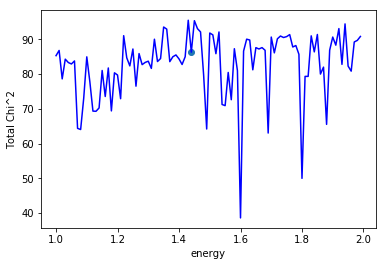

Text(0,0.5,'energy chi^2')

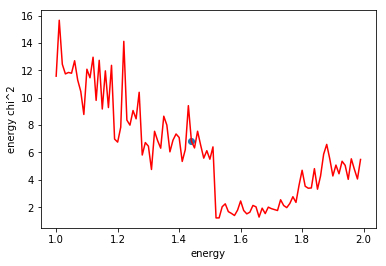

In [16]:
plt.plot(en_list, chi_list, 'b')
plt.scatter(1.44,chi_list[44])
plt.xlabel("energy")
plt.ylabel("Total Chi^2")
plt.show()
plt.plot(en_list, en_chi_list, 'r')
plt.scatter(1.44,en_chi_list[44])
plt.xlabel("energy")
plt.ylabel("energy chi^2")

In [19]:
i = 4.0
chi_list = []
azi_list = []
vert_chi_list = []
while i < 5.0:
    evtRandom, ctr = sim.make_event(good_p[0], good_p[1], good_p[2], good_p[3], i, good_p[5])
    pyevtRandom = sim.convert_event(evtRandom)
    Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    Random_xy = Random_xyzs[:, 0:2]
    Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
    Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
    Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
    uvw_sorted = Random_uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, Random_cu, Random_cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in Random_uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    ctr = np.zeros([1,6])
    ctr[0] = ctr0
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    chi_list.append(sum(chi_result[0]))
    azi_list.append(i)
    vert_chi_list.append(chi_result[0][2])
    i += 0.01

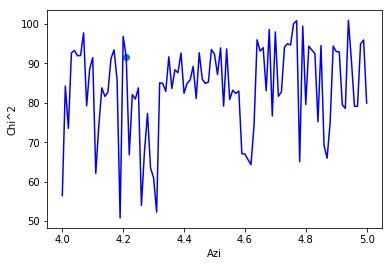

Text(0,0.5,'Azi chi^2')

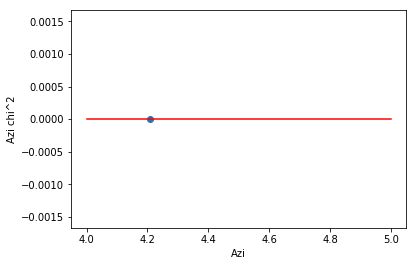

In [22]:
plt.plot(azi_list, chi_list, 'b')
plt.scatter(4.21,chi_list[21])
plt.xlabel("Azi")
plt.ylabel("Chi^2")
plt.show()
plt.plot(azi_list, vert_chi_list, 'r')
plt.scatter(4.21,vert_chi_list[21])
plt.xlabel("Azi")
plt.ylabel("vert chi^2")

In [24]:
i = 1.5
chi_list = []
pol_list = []
vert_chi_list = []
while i < 2.5:
    evtRandom, ctr = sim.make_event(good_p[0], good_p[1], good_p[2], good_p[3], good_p[4], i)
    pyevtRandom = sim.convert_event(evtRandom)
    Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    Random_xy = Random_xyzs[:, 0:2]
    Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
    Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
    Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
    uvw_sorted = Random_uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, Random_cu, Random_cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in Random_uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    ctr = np.zeros([1,6])
    ctr[0] = ctr0
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    chi_list.append(sum(chi_result[0]))
    pol_list.append(i)
    vert_chi_list.append(chi_result[0][2])
    i += 0.01

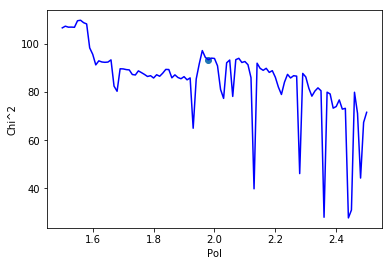

Text(0,0.5,'vert chi^2')

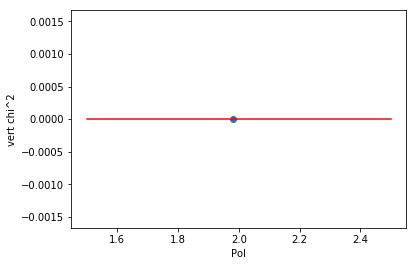

In [27]:
plt.plot(pol_list, chi_list, 'b')
plt.scatter(1.98,chi_list[48])
plt.xlabel("Pol")
plt.ylabel("Chi^2")
plt.show()
plt.plot(pol_list, vert_chi_list, 'r')
plt.scatter(1.98,vert_chi_list[48])
plt.xlabel("Pol")
plt.ylabel("vert chi^2")